**Objectives**  
- Transform to stationary time series  
- Develop forecasting models  
- Evaluate thier accuaracies  




In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, fftfreq
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#import data set
pdf = pd.read_csv('price_pivot.csv')
pdf.head()

,date,A,B,C,D,E
0,2022-08-28,54.500000,50.840000,29.920000,21.286667,31.943333
1,2022-08-29,54.870000,39.526667,34.060000,42.946667,22.993333
2,2022-08-30,54.483333,40.183333,32.520000,40.583333,26.693333
3,2022-08-31,52.096667,41.420000,32.293333,31.693333,26.850000
4,2022-09-01,51.770000,43.150000,36.340000,46.303333,31.306667


In [3]:
#product A series need to be transformed to stationary
#i use differencing method to make it
pdf['A diff'] = pdf['A'].diff()
pdf.head()

,date,A,B,C,D,E,A diff
0,2022-08-28,54.500000,50.840000,29.920000,21.286667,31.943333,NaN
1,2022-08-29,54.870000,39.526667,34.060000,42.946667,22.993333,0.370000
2,2022-08-30,54.483333,40.183333,32.520000,40.583333,26.693333,-0.386667
3,2022-08-31,52.096667,41.420000,32.293333,31.693333,26.850000,-2.386667
4,2022-09-01,51.770000,43.150000,36.340000,46.303333,31.306667,-0.326667


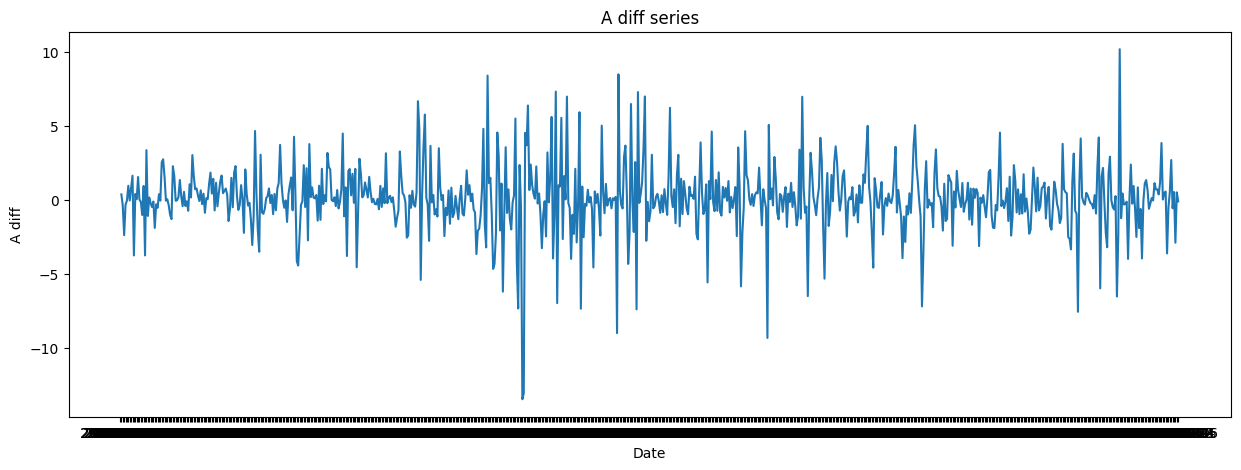

In [4]:
#plot the A diff series
plt.figure(figsize=(15,5))
plt.plot(pdf['date'],pdf['A diff'])
plt.title('A diff series')
plt.xlabel('Date')
plt.ylabel('A diff')
plt.show()

In [5]:
#adf test to check the p-value
adfuller_test = adfuller(pdf['A diff'].dropna())
print(f'A diff p-vale:{adfuller_test[1]}')

A diff p-vale:1.8147336561909758e-26


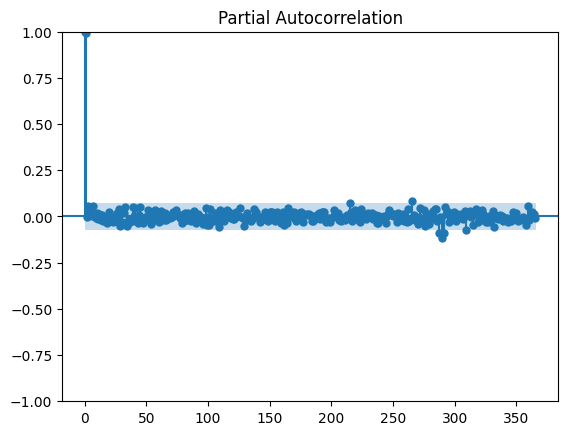

<Figure size 1500x300 with 0 Axes>

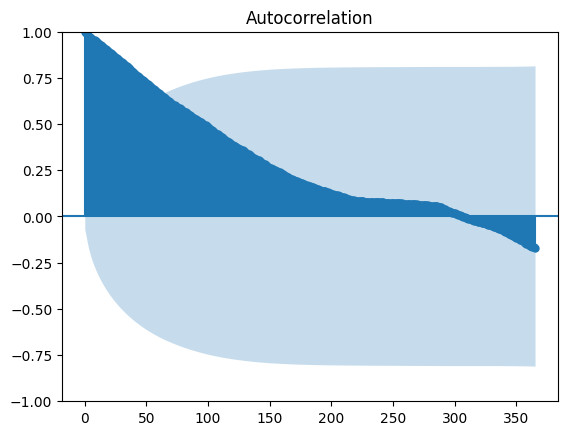

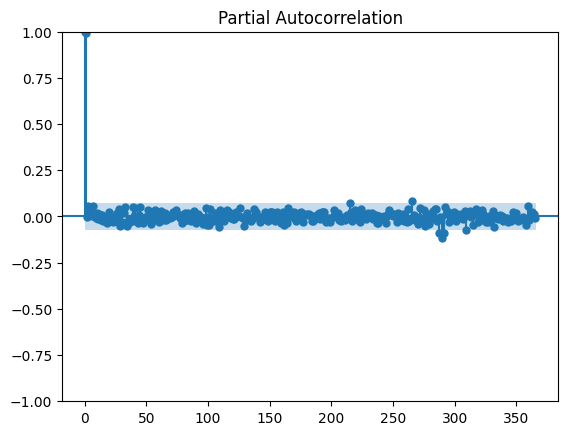

In [8]:
#plot the A diff series ACF and PACF
plt.figure(figsize=(15,3))
plot_acf(pdf['A'].dropna(), lags=365)
plot_pacf(pdf['A'].dropna(), lags=365)

**Training ARIMA Model**

p (Auto-Regressive term)  
Number of lagged observations included in the model (AR component).
Determines how many past values influence the current value.
Identified using Partial Autocorrelation Function (PACF).

d (Differencing order)  
Number of times the series needs to be differenced to make it stationary.
Identified using Augmented Dickey-Fuller (ADF) test.

q (Moving Average term)  
Number of lagged forecast errors included in the model (MA component).
Identified using Autocorrelation Function (ACF).

In [7]:
#train test split
train_size = int(len(pdf)*0.9)
train, test = pdf.iloc[:train_size], pdf.iloc[train_size:]

In [15]:
#fit ARIMA model
model = ARIMA(train['A'], order=(1, 1, 60))
model_fit = model.fit()

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


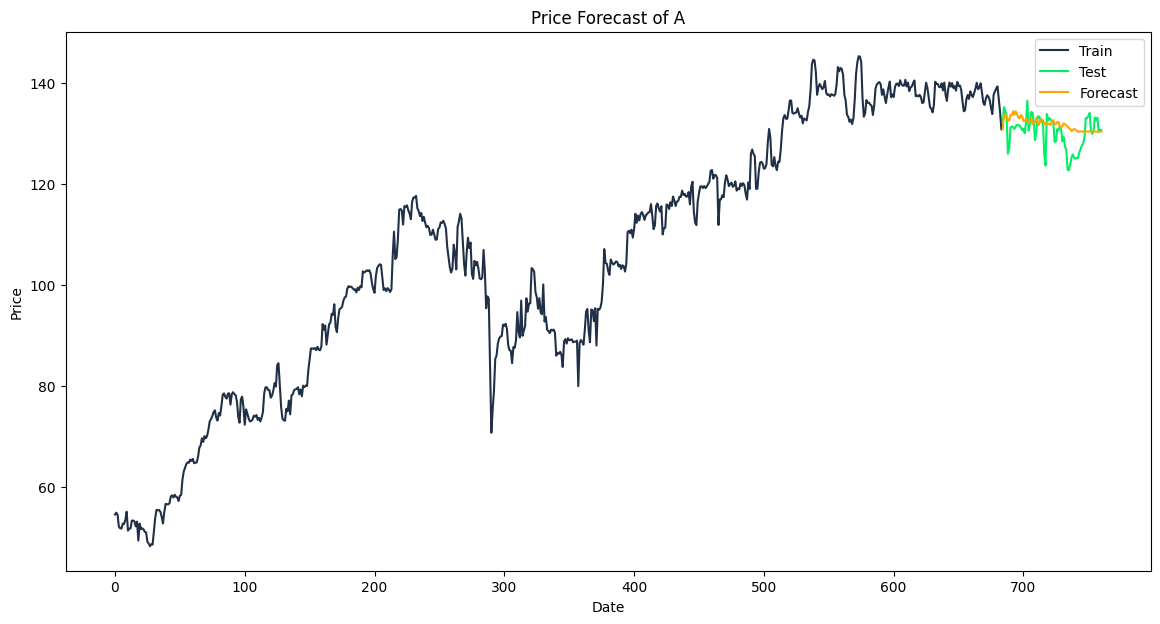

In [16]:
#forecasting using model
forecast = model_fit.forecast(steps=len(test))
# plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["A"], label='Train', color='#203147')
plt.plot(test.index, test["A"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Price Forecast of A')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 3053.293622682214
BIC: 3333.936303975603


In [18]:
#forecasting length
len(forecast)

77

In [ ]:
#model parameter tuning
results = []
for forecast_length in range(95, 99):
    for p in range(1, 3):
        for d in range(0, 2):
            for q in range(1, 3):
                train_size = int(len(pdf)*forecast_length/100)
                train, test = pdf.iloc[:train_size], pdf.iloc[train_size:]
                model = ARIMA(train['A diff'], order=(p, d, q))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                forecast_original = forecast.cumsum() + train["A"].iloc[-1]
                rmse = np.sqrt(mean_squared_error(test["A"], forecast_original))
                results.append({'Forecast_length': len(test), 'AR_order': p, 'I_order': d, 'MA_order': q,
                                'AIC': model_fit.aic, 'BIC': model_fit.bic, 'RMSE': rmse})

In [ ]:
metric_df_arima = pd.DataFrame(results).sort_values(by='RMSE', ascending=True, ignore_index=True)

In [ ]:
metric_df_arima.head(5)

,Forecast_length,AR_order,I_order,MA_order,AIC,BIC,RMSE
0,23,1,0,1,3310.057863,3328.473638,3.439158
1,23,1,0,2,3302.879149,3325.898868,3.622679
2,23,2,0,1,3302.290665,3325.310384,3.694136
3,23,2,0,2,3304.243570,3331.867233,3.712702
4,16,1,1,1,3368.667995,3382.504118,3.962162


In [ ]:
#best model parameters with optimal forecasting length
best_model = metric_df_arima.iloc[0]
best_model_params = best_model[['Forecast_length', 'AR_order', 'I_order', 'MA_order']].to_dict()    

In [ ]:
best_model_params

{'Forecast_length': 23.0, 'AR_order': 1.0, 'I_order': 0.0, 'MA_order': 1.0}

Previously I trained ARIMA model. We are assuming constant variance and seasonality free when using the ARIMA. The product A pice has seasonality and the trend. Therfore, we have to check the SARIMA model because it assume onle the constant variance of series. We can test fast fourier transform to check the cycles and seasonalities.

In [ ]:
# Perform FFT analysis
fft_res = fft(pdf['A'])
fft_fre = fftfreq(len(pdf['A']), 1)

In [ ]:
1/0.006

166.66666666666666